# NicheCompass Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 07.09.2023

- In order to run this notebook, a trained model needs to be stored under f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}".

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../utils")

In [3]:
import argparse
import gc
import os
import random
import shutil
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.stats as stats
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
# from pywaffle import Waffle

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                generate_enriched_gp_info_plots)

from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_physical_latent_for_cell_types,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_category_in_latent_and_physical_space,
                            sankey,
                            store_top_gps_summary)

### 1.2 Define Parameters

In [4]:
# dataset = "spatial_atac_rna_seq_mouse_brain_batch2"
dataset = "seqfish_mouse_organogenesis_imputed"
# dataset = "vizgen_merfish_human_colon_cancer"
# dataset = "vizgen_merfish_human_ovarian_cancer"
# dataset = "vizgen_merfish_human_lung_cancer"
# dataset = "nanostring_cosmx_human_nsclc_filtered"
# dataset = "nanostring_cosmx_human_nsclc"
# dataset = "starmap_plus_mouse_cns"
# dataset = "xenium_human_breast_cancer"
# dataset = "nanostring_cosmx_human_nsclc"

#### 1.2.1 Generic Parameters

In [5]:
## Model
# AnnData keys
adj_key = "spatial_connectivities"
spatial_key = "spatial"
sub_cell_type_key = "sub_cell_type"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
latent_key = "nichecompass_latent"
mapping_entity_key = "mapping_entity"

## Analysis
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

## Others
random_seed = 0

#### 1.2.2 Dataset-specific Parameters

In [6]:
multimodal = False
log_norm_omics_features = False
cell_type_groups = []
latent_groups = []

if dataset == "seqfish_mouse_organogenesis_imputed":
    load_timestamp = "09082023_225056_10"
    model_label = "one-hop-norm_reference"
    counts_key = "log_normalized_counts"
    cell_type_key = "celltype_mapped_refined"
    dataset_str = "seqFISH Mouse Organogenesis Imputed"
    multimodal = False
    sample_key = "sample"
    condition_key = "batch"
    latent_leiden_resolution = 0.35
    latent_groups = ["16", "15", "4", "10", "5", "6"]
    spot_size = 0.05
    cell_type_groups = []
    multimodal = False
elif dataset == "starmap_plus_mouse_cns":
    cell_type_key = "Main_molecular_cell_type"
    groups = "Astrocytes"
    dataset_str = "STARmap PLUS Mouse Central Nervous System"
    load_timestamp = "20062023_155306_1"
    #load_timestamp = "12062023_110439"
    #load_timestamp = "20062023_164533_42"
    model_label = "one-hop-norm_reference"
    condition_key = "batch"
    sample_key = "batch"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.2
    multimodal = False
    spot_size=0.2
    cell_type_groups = ["Microglia", "Pericytes"]
elif dataset == "visium_human_heart":
    load_timestamp = "15052023_102158"
    cell_type_key = "majority_cell_type"
    dataset_str = "Visium Human Heart"
    sample_key = "batch"
    samples = ["batch1", "batch2", "batch3"]
    condition_key = "batch"
    latent_leiden_resolution = 0.5
    latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
    latent_cluster_spot_size = 200
elif dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    load_timestamp = "09082023_145510_69"
    load_timestamp = "10082023_091319_10"
    #load_timestamp = "09082023_130425_21"
    model_label = "one-hop-norm_reference"
    cell_type_key = "RNA_clusters"
    rna_cluster_key = "RNA_clusters"
    atac_cluster_key = "ATAC_clusters"
    dataset_str = "Spatial ATAC-RNA-Seq Mouse Brain"
    sample_key = "batch"
    samples = ["p22"]
    condition_key = "batch"
    latent_leiden_resolution = 0.23 # 0.3
    latent_cluster_spot_size = 30
    latent_groups = []
    multimodal = True
    spot_size = 30
    cell_type_groups = []
    latent_groups = ["1", "6", "7", "5", "3"]
    log_norm_omics_features = True
elif dataset == "nanostring_cosmx_human_nsclc_filtered":
    load_timestamp = "12062023_123411"
    load_timestamp = "12062023_123012"
    load_timestamp = "11072023_130002_1"
    model_label = "one-hop-norm_reference"
    dataset_str = "Nanostring CosMx Human NSCLC"
    condition_key = "batch"
    latent_leiden_resolution = 0.03
    latent_cluster_spot_size = 60
    sample_key = "batch"
    multimodal = False
    spot_size = 50
    cell_type_key = "cell_type"
elif dataset == "vizgen_merfish_human_colon_cancer":
    load_timestamp = "27062023_113037_2"
    model_label = "one-hop-norm_reference"
    dataset_str = "Vizgen MERFISH Human Colon Cancer"
    condition_key = "sample"
    sample_key = "batch"
    samples = ["batch1", "batch2"]
    latent_leiden_resolution = 0.5
    latent_cluster_spot_size = 30
elif dataset == "vizgen_merfish_human_ovarian_cancer":
    load_timestamp = "13062023_131002"
    load_timestamp = "27062023_113037_2"
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Vizgen MERFISH Human Ovarian Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
elif dataset == "vizgen_merfish_human_lung_cancer":
    load_timestamp = "13062023_131002"
    load_timestamp = "19062023_140621_1"
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Vizgen MERFISH Human Lung Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
elif dataset == "xenium_human_breast_cancer":
    load_timestamp = "28082023_182430_3" # 12 neighbors
    # load_timestamp = "20062023_120357_1" # 4 neighbors
    model_label = "reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Xenium Human Breast Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_states"
elif dataset == "nanostring_cosmx_human_nsclc":
    load_timestamp = "01092023_183450_7"
    model_label = "reference"
    latent_leiden_resolution = 0.4
    latent_cluster_spot_size = 0.03
    dataset_str = "nanoString CosMx Human NSCLC"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [7]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [8]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

### 1.4 Configure Paths and Create Directories

In [9]:
# Define paths
figure_folder_path = f"../artifacts/{dataset}/figures/{model_label}/{load_timestamp}"
model_folder_path = f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}"
result_folder_path = f"../artifacts/{dataset}/results/{model_label}/{load_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
ga_data_folder_path = "../datasets/ga_data"
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

## 2. Model

### 2.1 Load Model

In [10]:
if model_label == "sample_integration_method_benchmarking":
    model_folder_path = f"{model_folder_path}/run{run_number}"

In [11]:
if multimodal:
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              adata_atac=None,
                              adata_atac_file_name=f"{dataset}_{model_label}_atac.h5ad",
                              gp_names_key=gp_names_key)
else:
    # Load trained model
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
CATEGORICAL COVARIATES EMBEDDINGS INJECTION -> ['gene_expr_decoder']
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 5000, n_cat_covariates_embed_input: 0, n_hidden: 1631, n_latent: 1531, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, use_bn: False
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 1531, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 5000
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 1531, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 5000


In [12]:
model.adata.uns[gp_names_key] = np.array([gp for gp in model.adata.uns[gp_names_key] if not "Add-on " in gp])
model.adata.uns[active_gp_names_key] = np.array([gp for gp in model.adata.uns[active_gp_names_key] if not "Add-on " in gp])
model.adata.uns[gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[gp_names_key]])
model.adata.uns[active_gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[active_gp_names_key]])

## 3. Analysis

In [13]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1631.
Number of active gene programs: 1108.


In [14]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][0:20]

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,EPOR_ligand_receptor_GP,0,True,0,1,1,0,0,[Epor],[],[1.0829],[],[1.0],[]
1,TP53_ligand_receptor_GP,1,True,1,1,1,0,0,[Trp53],[],[-0.4539],[],[1.0],[]
2,NPPA_ligand_receptor_GP,2,True,2,1,1,1,1,[Nppa],[Prkg1],[-1.5607],[-1.1115],[0.5841],[0.4159]
3,CXCL12_ligand_receptor_GP,3,True,3,1,1,0,0,[Cxcl12],[],[-0.5384],[],[1.0],[]
4,PTPN11_ligand_receptor_GP,4,True,4,1,1,0,0,[Ptpn11],[],[0.0245],[],[1.0],[]
5,EFNB3_ligand_receptor_GP,5,True,5,1,1,0,0,[Efnb3],[],[-0.0992],[],[1.0],[]
6,EFNB1_ligand_receptor_GP,6,True,6,1,1,0,0,[Efnb1],[],[0.1334],[],[1.0],[]
8,S100A1_ligand_receptor_GP,8,True,7,1,1,0,0,[S100a1],[],[-1.1433],[],[1.0],[]
9,GSTO1_ligand_receptor_GP,9,True,8,1,1,0,0,[Gsto1],[],[0.0138],[],[1.0],[]
10,CCL27_ligand_receptor_GP,10,True,9,1,1,0,0,[Ccl27a],[],[-0.5358],[],[1.0],[]


In [15]:
model.add_active_gp_scores_to_obs()

In [ ]:
model.model.features_idx_dict_["target_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_rna_idx"], model.model.features_idx_dict_["target_unmasked_rna_idx"])))
model.model.features_idx_dict_["source_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_rna_idx"], model.model.features_idx_dict_["source_unmasked_rna_idx"])))

output = model.get_omics_decoder_outputs(
                adata=model.adata,
                counts_key=model.counts_key_,
                adj_key=model.adj_key_,
                cat_covariates_keys=model.cat_covariates_keys_,
                only_active_gps=True,
                node_batch_size=2048)

gene = "Egr2"
model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=gene,
    color_map="RdPu",
    spot_size=spot_size,
    title=gene,
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gene}_rec",
    color_map="RdPu",
    spot_size=spot_size,
    title=gene,
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

### 3.1 Analyze Latent Manifold

In [16]:
samples = model.adata.obs[sample_key].unique().tolist()

In [ ]:
if model.adata.obs[mapping_entity_key].nunique() > 1:
    # Plot mapping entities in latent and physical space
    mapping_entity_colors = create_new_color_dict(
        adata=model.adata,
        cat_key=mapping_entity_key)
    
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "mapping_entities_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Mapping Entities",
        cat_key=mapping_entity_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=mapping_entity_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
# Plot batches in latent and physical space
condition_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="batch",
    cat_key=condition_key)

save_fig = True
file_path = f"{figure_folder_path}/" \
            "batches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Batches",
    cat_key=condition_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=condition_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
# Plot cell types in latent and physical space
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="cell_type",
    cat_key=cell_type_key)

save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Cell Types",
    cat_key=cell_type_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=cell_type_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
if len(cell_type_groups) > 0:
    # Plot cell type groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(cell_type_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [16]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [17]:
# Plot latent clusters in latent and physical space
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Latent Clusters",
    cat_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=latent_cluster_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

NameError: name 'samples' is not defined

In [ ]:
if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    fig, ax = plt.subplots(figsize=(20, 10))
    sankey(
        x=model.adata.obs[latent_cluster_key],
        y=model.adata.obs[rna_cluster_key],
        title="NicheCompass Label vs Original Label",
        title_left="NicheCompass Label",
        title_right="Original Label",
        ax=ax,
        fontsize="10",  # "xx-small",
        left_order=model.adata.obs[latent_cluster_key].unique().tolist(),
        colorside="left",
        alpha=0.5,
    )
    plt.show()

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    # Latent clusters in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_cluster_{latent_cluster}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Latent Clusters",
        cat_key=latent_cluster_key,
        groups=latent_cluster,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if dataset == "seqfish_mouse_organogenesis_imputed":
    gp_resign = True
    
    niche_annotation_dict = {
        "0": "Saa1 GP/Il6st GP+ Muscles",
        "1": "Bmp8a GP/9-cis-Ret. acid GP+ Splanchnic Mesoderm",
        "2": "IL10 GP/Fgf2 GP+ Angiogenesis",
        "3": "Nptn GP/Fgf8 GP+ Spinal cord",
        "4": "Ihh GP/Spint1 GP+ Ventral Gut",
        "5": "Pcsk1n GP/Dkk1 GP+ Forebrain",
        "6": "Fgf17 GP/Efna2 GP+ Midbrain",
        "7": "Tgfbi GP/Fgf6 GP+ Cranial Mesoderm",
        "8": "Guanine GP/Slitrk1 GP+ Neural Crest (Neural Tube)",
        "9": "Sfrp4 GP/Pdgfa GP+ Surface Ectoderm",
        "10": "Gdf10 GP/Fgf3 GP+ Hindbrain",
        "11": "Edn1 GP/Nppa1 GP+ Developing Heart",
        "12": "Epo GP/Thpo GP+ Hematopoiesis",
        "13": "Bmp4 GP/Vegfb GP+ Lateral Plate Mesoderm",
        "14": "Cdh13 GP/Col1a1 GP+ Mixed mesenchymal mesoderm",
        "15": "Calca GP/Shh GP+ Floor Plate",
        "16": "Cthrc1 GP/Pdgfc GP+ Dorsal Gut",
        "17": "Fgf18 GP/Dll1 GP+ Presomitic Mesoderm",
        "18": "Pgf GP/Cd44 GP+ Allantois",
        "19": "Mix"
    }

    model.adata.obs["niche"] = model.adata.obs["latent_leiden_0.35"].map(niche_annotation_dict)
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    sc.tl.dendrogram(adata=model.adata,
                     use_rep="nichecompass_latent",
                     linkage_method="single",
                     groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax,
        save="dendrogram_nichecompass_latent.svg")
    plt.show()

    fig, ax = plt.subplots(figsize=(17, 21))
    sankey(
        x=model.adata.obs[cell_type_key],
        y=model.adata.obs["niche"],
        title="Cell Type to Niche Mapping",
        title_left="Cell Type Label",
        title_right="Niche Label",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=["Mixed mesenchymal mesoderm", "Lateral plate mesoderm", "Intermediate mesoderm", "Allantois", "Splanchnic mesoderm",
        #            "ExE endoderm", "Cardiomyocytes", "Definitive endoderm", "Gut tube", "Surface ectoderm", "Neural crest", "Cranial mesoderm",
        #            "Erythroid", "Blood progenitors", "Endothelium", "Haematoendothelial progenitors", "Forebrain/Midbrain/Hindbrain",
        #            "Spinal cord", "NMP", "Dermomyotome", "Sclerotome", "Anterior somitic tissues", "Presomitic mesoderm"],
        colors=cell_type_colors,
        alpha=0.5,
    )
    plt.savefig(f"{figure_folder_path}/sankey_cell_type_to_niche.svg")
    plt.show()
    
    gps = [
        "Cdh13_ligand_receptor_target_gene_GP", "Col1a1_ligand_receptor_target_gene_GP",        
        "BMP4_ligand_receptor_GP", "Vegfb_ligand_receptor_target_gene_GP",  
        "Pgf_ligand_receptor_target_gene_GP", "Cd44_ligand_receptor_target_gene_GP",
        "Bmp8a_ligand_receptor_target_gene_GP", "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
        "Edn1_ligand_receptor_target_gene_GP", "NPPA_ligand_receptor_GP",
        "Cthrc1_ligand_receptor_target_gene_GP", "PDGFC_ligand_receptor_GP",
        "IHH_ligand_receptor_GP", "Spint1_ligand_receptor_target_gene_GP",
        "SFRP4_ligand_receptor_GP", "PDGFA_ligand_receptor_GP",
        "Guanine_metabolite_enzyme_sensor_GP", "Slitrk1_ligand_receptor_target_gene_GP",
        "Tgfbi_ligand_receptor_target_gene_GP", "FGF6_ligand_receptor_GP",
        "Epo_ligand_receptor_target_gene_GP", "Thpo_ligand_receptor_target_gene_GP",
        "Il10_ligand_receptor_target_gene_GP", "Fgf2_ligand_receptor_target_gene_GP",
        "Fgf17_ligand_receptor_target_gene_GP", "Efna2_ligand_receptor_target_gene_GP",
        "PCSK1N_ligand_receptor_GP", "DKK1_ligand_receptor_GP",
        "Calca_ligand_receptor_target_gene_GP", "Shh_ligand_receptor_target_gene_GP",
        "Gdf10_ligand_receptor_target_gene_GP", "Fgf3_ligand_receptor_target_gene_GP",
        "NPTN_ligand_receptor_GP", "Fgf8_ligand_receptor_target_gene_GP",
        "SAA1_ligand_receptor_GP", "IL6ST_ligand_receptor_GP",
         "Fgf18_ligand_receptor_target_gene_GP", "Dll1_ligand_receptor_target_gene_GP",    
    ]
    
    resign_gps = [
        "IL6ST_ligand_receptor_GP",
        "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
        "Il10_ligand_receptor_target_gene_GP",
        "Fgf8_ligand_receptor_target_gene_GP",
        "Oleic_acid_metabolite_enzyme_sensor_GP",
        "L-Threonine_metabolite_enzyme_sensor_GP",
        "Efna2_ligand_receptor_target_gene_GP",
        "Slitrk1_ligand_receptor_target_gene_GP",
        "Fgf3_ligand_receptor_target_gene_GP",
        "NPPA_ligand_receptor_GP",
        "Thpo_ligand_receptor_target_gene_GP",
        "Calca_ligand_receptor_target_gene_GP",
        "PDGFC_ligand_receptor_GP",
        "Dll1_ligand_receptor_target_gene_GP",
        "Cthrc1_ligand_receptor_target_gene_GP",
        "Bmp8a_ligand_receptor_target_gene_GP",
        "Spint1_ligand_receptor_target_gene_GP",
        "FGF6_ligand_receptor_GP",
        "SFRP4_ligand_receptor_GP",
        "VCAM1_ligand_receptor_GP",
    ]
    
    if gp_resign:
        for gp in resign_gps:
            model.adata.obs[gp] = -1 * model.adata.obs[gp]
    
    df = model.adata.obs[["niche"] + gps].groupby("niche").mean()
    df = df.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::-1])

    scaler = MinMaxScaler()
    normalized_columns = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
    normalized_df.index = df.index
    normalized_df.columns = [col.split("_lig")[0].split("_met")[0].replace("_", " ").replace("9-cis-Retinoic", "9-cis-Ret.") + " GP" for col in normalized_df.columns]

    plt.figure(figsize=(13, 6))  # Set the figure size
    ax = sns.heatmap(normalized_df,
                cmap='viridis',
                annot=False,
                linewidths=0)
    plt.xticks(rotation=45,
               fontsize=10,
               ha="right"
              )
    plt.xlabel("Communication Gene Programs", fontsize=16)
    plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
                bbox_inches="tight")
    
    plt.figure(figsize=(13, 6))  # Set the figure size
    ax = sns.heatmap(normalized_df,
                cmap='viridis',
                annot=False,
                linewidths=0,
                cbar_kws={"orientation": "horizontal", "location": "bottom", "shrink": 0.4})
    plt.xticks([])
    plt.savefig(f"{figure_folder_path}/heatmap_colorbar.svg",
                bbox_inches="tight")
    
    tmp = pd.crosstab(model.adata.obs["niche"],model.adata.obs['batch'], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    tmp.index = [gp_name.split("+ ")[1] if "+" in gp_name else gp_name for gp_name in tmp.index.tolist()]
    ax = tmp.plot.barh(color=condition_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=20)
    plt.xlabel("Data Source Proportions", fontsize=20)
    plt.savefig(f"{figure_folder_path}/niche_batch_proportions.svg", bbox_inches='tight')

    tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=16)
    plt.xlabel("Cell Type Proportions", fontsize=24)
    plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions.svg", bbox_inches='tight')
    
    sc.tl.dendrogram(adata=model.adata,
                         var_names=gps,
                         linkage_method="single",
                         groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax)
    plt.show()
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "forebrain_latent_physical_space.svg"
    
    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Pcsk1n GP/Dkk1 GP+ Forebrain"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "midbrain_latent_physical_space.svg"
    
    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Fgf17 GP/Efna2 GP+ Midbrain"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "hindbrain_latent_physical_space.svg"
    
    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Gdf10 GP/Fgf3 GP+ Hindbrain"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "floorplate_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Calca GP/Shh GP+ Floor Plate"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    color_map = "RdGy_r"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    # Forebrain
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="PCSK1N_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="DKK1_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Fgf17_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Efna2_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Calca_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Shh_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Gdf10_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Fgf3_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)
    
    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps.svg",
                bbox_inches="tight")
    
    adata_top = model.adata[model.adata.obsm["spatial"][:,1] < 0]
    adata_top = adata_top[adata_top.obs["sample"] == "embryo2"]
    
    for gp in gps:
        scaler = MinMaxScaler()
        # Fit and transform the column to normalize its values
        adata_top.obs[f'{gp}_normalized'] = scaler.fit_transform(adata_top.obs[[gp]])

    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    
    # Forebrain
    sc.pl.spatial(
        adata=adata_top,
        color="PCSK1N_ligand_receptor_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="DKK1_ligand_receptor_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf17_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Efna2_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=adata_top,
        color="Calca_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Shh_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Gdf10_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf3_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps_top.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                                ncols=2,
                                figsize=(15, 15))

    # Forebrain
    sc.pl.spatial(
        adata=adata_top,
        color="Pcsk1n",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Dkk1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf17",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Efna2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=adata_top,
        color="Calca",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Shh",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Gdf10",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf3",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps_genes.svg",
                bbox_inches="tight")
    
    # Shh GP
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                                ncols=2,
                                figsize=(15, 15))

    # Ligand
    sc.pl.spatial(
        adata=adata_top,
        color="Shh",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)

    # Receptor
    sc.pl.spatial(
        adata=adata_top,
        color="Ptch1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ptch1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Top 5 Target Genes
    sc.pl.spatial(
        adata=adata_top,
        color="Nkx2-9",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nkx2-9",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Foxf2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Foxf2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Slit2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Slit2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Mnx1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mnx1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Foxd1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Foxd1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)


    plt.show()
    fig.savefig(f"{figure_folder_path}/shh_ligand_receptor_target_gene_gp.svg",
                bbox_inches="tight")
    
    value_mapping = {"5": "Forebrain",
                     "6": "Midbrain",
                     "10": "Hindbrain",
                     "15": "Floor Plate"}
    category_colors = {'Forebrain': latent_cluster_colors["5"],
                       'Midbrain': latent_cluster_colors["6"],
                       'Hindbrain': latent_cluster_colors["10"],
                       'Floor Plate': latent_cluster_colors["15"]}

    def map_values(value):
        if value in value_mapping:
            return value_mapping[value]
        else:
            return np.nan

    model.adata.obs['Brain Niches'] = model.adata.obs['latent_leiden_0.35'].apply(map_values)

    with sns.axes_style("ticks"):
        # Floor Plate (Tegmentum)
        ax = sns.scatterplot(x='Shh_ligand_receptor_target_gene_GP', # Pixna1_ligand_receptor_target_gene_GP
                        y='Calca_ligand_receptor_target_gene_GP',
                        hue='Brain Niches',
                        data=model.adata.obs,
                        palette=category_colors)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel("Shh GP")
        plt.ylabel("Calca GP")
        plt.savefig(f"{figure_folder_path}/floorplate_scatterplot.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
    
    # Dorsal Gut
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "dorsalgut_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Cthrc1 GP/Pdgfc GP+ Dorsal Gut"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    # Ventral Gut
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "ventralgut_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Ihh GP/Spint1 GP+ Ventral Gut"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    adata_gut = model.adata[model.adata.obsm["spatial"][:,1] < 2.8]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,1] > -1.6]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] < 1.3]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] > -1.2]
    adata_gut = adata_gut[adata_gut.obs["sample"] == "embryo2"]
    
    for gp in gps:
        scaler = MinMaxScaler()
        # Fit and transform the column to normalize its values
        adata_gut.obs[f'{gp}_normalized'] = scaler.fit_transform(adata_gut.obs[[gp]])

    color_map = "RdGy_r"
    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="IHH_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ihh GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="PDGFC_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pdgfc GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/gut_enriched_gps.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Ihh",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ihh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Pdgfc",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pdgfc",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/gut_enriched_gps_genes.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ligand
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    
    # Receptor
    sc.pl.spatial(
        adata=adata_gut,
        color="St14",
        color_map=color_map,
        spot_size=spot_size,
        title=f"St14",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Mmp14",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mmp14",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Fstl1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fstl1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/spint1_ligand_receptor_target_gene_gp.svg",
                bbox_inches="tight")
    
    for gene in ["Spint1", "Ihh", "Cthrc1", "Pdgfc"]:
        model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]
        
    adata_gut = model.adata[model.adata.obsm["spatial"][:,1] < 2.8]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,1] > -1.6]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] < 1.3]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] > -1.2]
    adata_gut = adata_gut[adata_gut.obs["sample"] == "embryo2"]
    
    adata_gut.obs["Vtn_ligand_receptor_target_gene_GP"] = -1 *  adata_gut.obs["Vtn_ligand_receptor_target_gene_GP"] 
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Ihh_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ihh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Pdgfc_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pdgfc",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/gut_enriched_gps_reconstructed_genes.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(25, 15))
    
    # Ligand
    sc.pl.spatial(
        adata=adata_gut,
        color="Vtn",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vtn",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    
    # Receptor
    sc.pl.spatial(
        adata=adata_gut,
        color="Itga2b",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Itga2b",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Itga5",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Itga5",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)    

    # Target Genes
    sc.pl.spatial(
        adata=adata_gut,
        color="Pxdn",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pxdn",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Mecom",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mecom",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Kdr",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Kdr",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Crem",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Crem",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    
    # GP
    color_map = "RdGy_r"
    sc.pl.spatial(
    adata=adata_gut,
    color="Vtn_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Vtn GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/vtn_ligand_receptor_target_gene_gp.svg",
                bbox_inches="tight")
    
    model.model.features_idx_dict_["target_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_rna_idx"], model.model.features_idx_dict_["target_unmasked_rna_idx"])))
    model.model.features_idx_dict_["source_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_rna_idx"], model.model.features_idx_dict_["source_unmasked_rna_idx"])))

    output = model.get_omics_decoder_outputs(
                    adata=model.adata,
                    counts_key=model.counts_key_,
                    adj_key=model.adj_key_,
                    cat_covariates_keys=model.cat_covariates_keys_,
                    only_active_gps=True,
                    node_batch_size=2048)

    for gene in ["Pcsk1n", "Dkk1", "Fgf17", "Efna2", "Calca", "Shh", "Gdf10", "Fgf3"]:
        model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]
    
    adata_top = model.adata[model.adata.obsm["spatial"][:,1] < 0]
    adata_top = adata_top[adata_top.obs["sample"] == "embryo2"]
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                                ncols=2,
                                figsize=(15, 15))

    # Forebrain
    sc.pl.spatial(
        adata=adata_top,
        color="Pcsk1n_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Dkk1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf17_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Efna2_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=adata_top,
        color="Calca_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Shh_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Gdf10_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf3_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps_reconstructed_genes.svg",
                bbox_inches="tight")
    
    for gene in ["Ihh", "Spint1", "Cthrc1", "Pdgfc"]:
            model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

In [ ]:
gp_summary_df[gp_summary_df["gp_name"] == "Shh_ligand_receptor_target_gene_GP"]

In [ ]:
niche_groups = ["IL10 GP/Fgf2 GP+ Angiogenesis"]

if len(niche_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/angiogenesis_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(niche_groups)}",
        cat_key="niche",
        groups=niche_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [26]:
if dataset == "seqfish_mouse_organogenesis_imputed":
    gp_resign = True
    
    niche_annotation_dict = {
        "0": "Saa1 GP/Il6st GP+ Muscles",
        "1": "Bmp8a GP/9-cis-Ret. acid GP+ Splanchnic Mesoderm",
        "2": "IL10 GP/Fgf2 GP+ Angiogenesis",
        "3": "Nptn GP/Fgf8 GP+ Spinal cord",
        "4": "Ihh GP/Spint1 GP+ Ventral Gut",
        "5": "Pcsk1n GP/Dkk1 GP+ Forebrain",
        "6": "Fgf17 GP/Efna2 GP+ Midbrain",
        "7": "Tgfbi GP/Fgf6 GP+ Cranial Mesoderm",
        "8": "Guanine GP/Slitrk1 GP+ Neural Crest (Neural Tube)",
        "9": "Sfrp4 GP/Pdgfa GP+ Surface Ectoderm",
        "10": "Gdf10 GP/Fgf3 GP+ Hindbrain",
        "11": "Edn1 GP/Nppa1 GP+ Developing Heart",
        "12": "Epo GP/Thpo GP+ Hematopoiesis",
        "13": "Bmp4 GP/Vegfb GP+ Lateral Plate Mesoderm",
        "14": "Cdh13 GP/Col1a1 GP+ Mixed mesenchymal mesoderm",
        "15": "Calca GP/Shh GP+ Floor Plate",
        "16": "Cthrc1 GP/Pdgfc GP+ Dorsal Gut",
        "17": "Fgf18 GP/Dll1 GP+ Presomitic Mesoderm",
        "18": "Pgf GP/Cd44 GP+ Allantois",
        "19": "Mix"
    }

    model.adata.obs["niche"] = model.adata.obs["latent_leiden_0.35"].map(niche_annotation_dict)

In [ ]:
gp = "Shh_ligand_receptor_target_gene_GP"
ligand_genes = [
    "Shh"]
receptor_genes = [gene for gene in [
    'Boc',
    'Cdon',
    'Hhip',
    'Lrp2',
    'Ptch1',
    'Ptch2',
    'Smo'] if gene in gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]]
target_genes = list(set(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]) - set(receptor_genes))
gp_sign = 1

model.adata.obs[f"{gp}_sign_corrected"] = gp_sign * model.adata.obs[gp]

gp_ligand_scores = np.zeros((len(model.adata.obs), len(ligand_genes)))
gp_receptor_scores = np.zeros((len(model.adata.obs), len(receptor_genes)))
gp_target_scores = np.zeros((len(model.adata.obs), len(target_genes)))

for i, ligand_gene in enumerate(ligand_genes):
    gp_ligand_scores[:, i] = (
        model.adata[:, model.adata.var_names.tolist().index(ligand_gene)].X.toarray().flatten() *
        gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0][gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0].index(ligand_gene)] *
        gp_sign * # correct sign of weights
        model.adata.obs[f"{gp}_sign_corrected"])
    
for j, receptor_gene in enumerate(receptor_genes):
    gp_receptor_scores[:, j] = (
        model.adata[:, model.adata.var_names.tolist().index(receptor_gene)].X.toarray().flatten() *
        gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0][gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0].index(receptor_gene)] *
        gp_sign * # correct sign of weights
        model.adata.obs[f"{gp}_sign_corrected"])
    
for k, target_gene in enumerate(target_genes):
    gp_target_scores[:, k] = (
        model.adata[:, model.adata.var_names.tolist().index(target_gene)].X.toarray().flatten() *
        gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0][gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0].index(target_gene)] *
        gp_sign * # correct sign of weights
        model.adata.obs[f"{gp}_sign_corrected"])
    
agg_gp_source_score = gp_ligand_scores.mean(1)
agg_gp_target_score = gp_receptor_scores.mean(1) * gp_target_scores.mean(1)

agg_gp_source_score[agg_gp_source_score < 0] = 0.
agg_gp_target_score[agg_gp_target_score < 0] = 0.

model.adata.obs[f"{gp}_source_score"] = agg_gp_source_score
model.adata.obs[f"{gp}_target_score"] = agg_gp_target_score

color_map = "RdPu"
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(15, 15))
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gp}_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"{gp}_sign_corrected",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)

sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gp}_source_score",
    color_map=color_map,
    spot_size=spot_size,
    title=f"{gp}_source_score",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gp}_target_score",
    color_map=color_map,
    spot_size=spot_size,
    title=f"{gp}_target_score",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cci_scores_{gp}.svg",
            bbox_inches="tight")

score_matrix = np.outer(model.adata.obs[f"{gp}_source_score"], model.adata.obs[f"{gp}_target_score"])

n_neighbors = 90

# Compute neighborhood graph
sc.pp.neighbors(model.adata,
                n_neighbors=n_neighbors,
                use_rep="spatial",
                key_added="spatial_cci")

model.adata.obsp[f"{gp}_connectivities"] = (model.adata.obsp["spatial_cci_connectivities"] > 0).multiply(sp.csr_matrix(score_matrix))

# Get cell type neighbor importances for each niche / latent cluster
network_df_pivoted = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=f"{gp}_connectivities",
    cell_type_key="niche",
    group_key=None,
    agg_rows=True)

network_df_pivoted.to_csv(f"{gp}_network_score_pivoted.csv")

network_df = network_df_pivoted.melt(var_name="source_niche", value_name="gp_score", ignore_index=False).reset_index()
network_df.columns = ["source", "target", "strength"]
network_df["source"] = network_df["source"].apply(lambda x: x.split("GP+ ")[1] if "GP+ " in x else x)
network_df["target"] = network_df["target"].apply(lambda x: x.split("GP+ ")[1] if "GP+ " in x else x)

network_df = network_df.sort_values("strength", ascending=False)

min_value = network_df['strength'].min()
max_value = network_df['strength'].max()

network_df['strength'] = (network_df['strength'] - min_value) / (max_value - min_value)

network_df["strength"] = np.round(network_df["strength"], 2)
network_df = network_df[network_df["strength"] > 0]

network_df["edge_type"] = gp

network_df.to_csv(f"{gp}_network_score.csv", index=False)

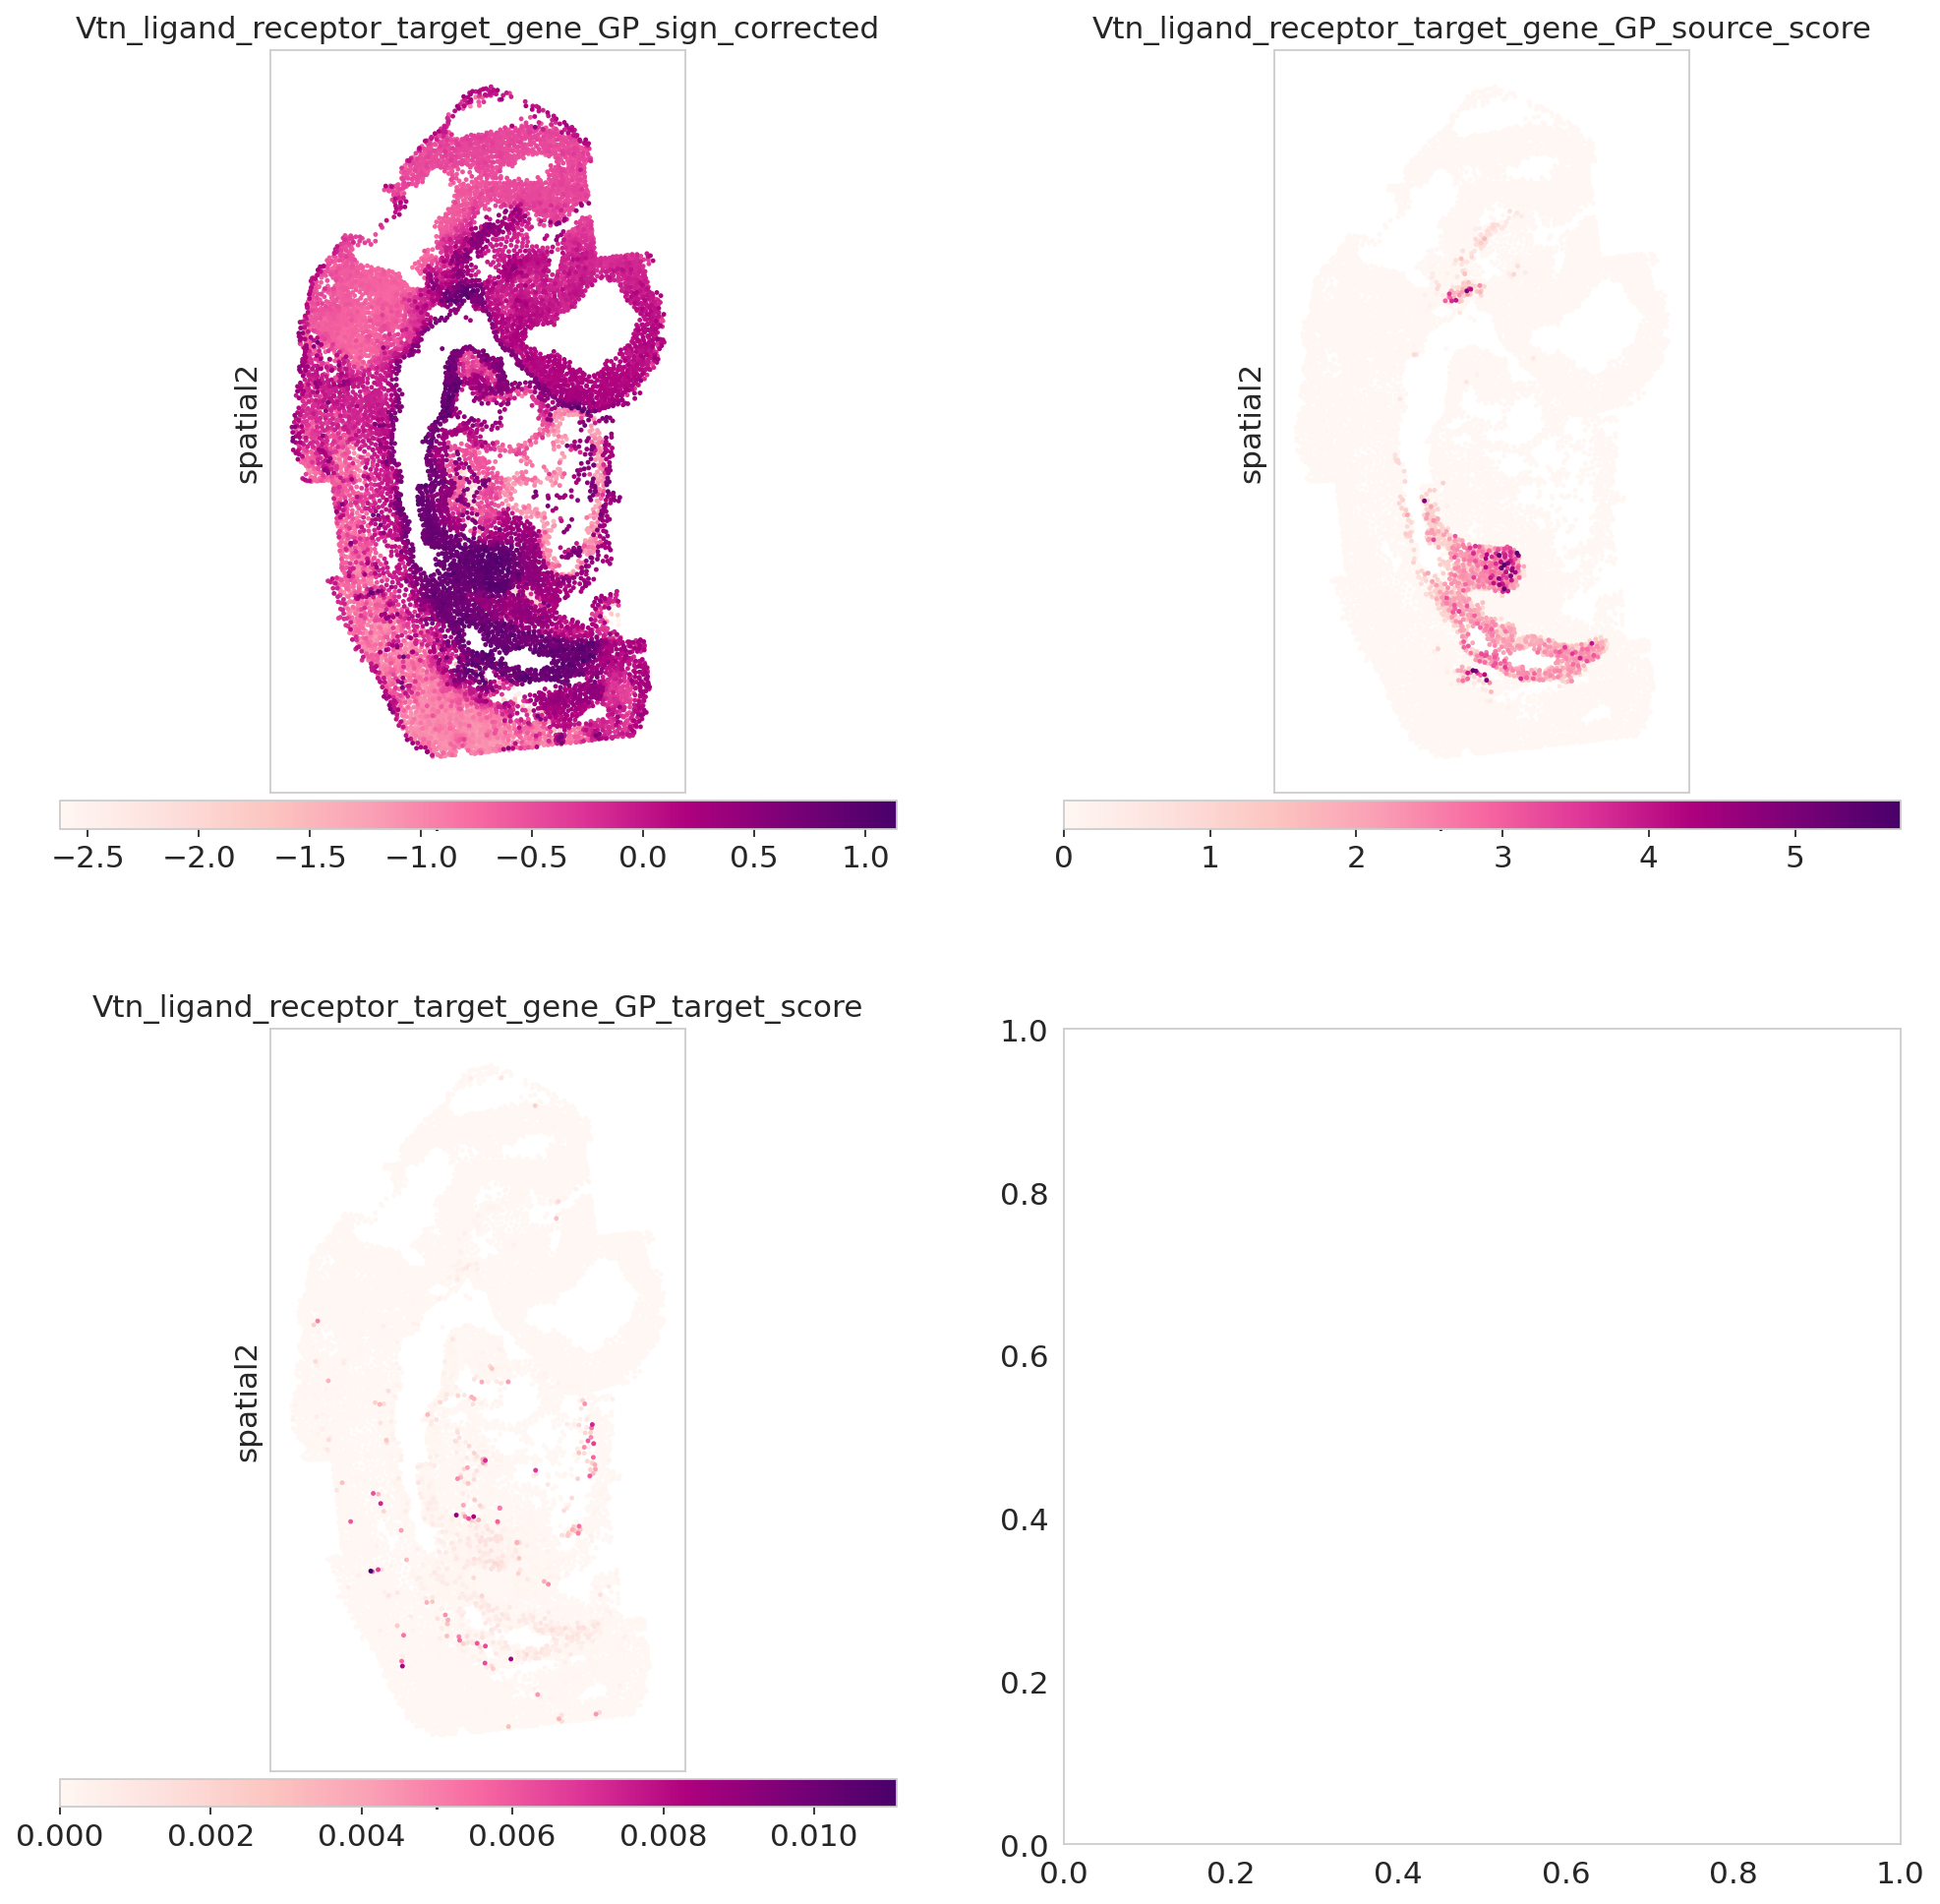

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cartalop/minicon

In [20]:
gp = "Vtn_ligand_receptor_target_gene_GP"
ligand_genes = [
    "Vtn"]
receptor_genes = [gene for gene in [
    'Itga2b',
    'Itga5',
    'Itga8',
    'Itgav',
    'Itgb1',
    'Itgb3',
    'Itgb5',
    'Itgb6',
    'Itgb8',
    'Kdr',
    'Plaur',
    'Pvr',
    'Tnfrsf11b'] if gene in gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]]
target_genes = list(set(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]) - set(receptor_genes))
gp_sign = -1

model.adata.obs[f"{gp}_sign_corrected"] = gp_sign * model.adata.obs[gp]

gp_ligand_scores = np.zeros((len(model.adata.obs), len(ligand_genes)))
gp_receptor_scores = np.zeros((len(model.adata.obs), len(receptor_genes)))
gp_target_scores = np.zeros((len(model.adata.obs), len(target_genes)))

for i, ligand_gene in enumerate(ligand_genes):
    gp_ligand_scores[:, i] = (
        model.adata[:, model.adata.var_names.tolist().index(ligand_gene)].X.toarray().flatten() *
        gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0][gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0].index(ligand_gene)] *
        gp_sign * # correct sign of weights
        model.adata.obs[f"{gp}_sign_corrected"])
    
for j, receptor_gene in enumerate(receptor_genes):
    gp_receptor_scores[:, j] = (
        model.adata[:, model.adata.var_names.tolist().index(receptor_gene)].X.toarray().flatten() *
        gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0][gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0].index(receptor_gene)] *
        gp_sign * # correct sign of weights
        model.adata.obs[f"{gp}_sign_corrected"])
    
for k, target_gene in enumerate(target_genes):
    gp_target_scores[:, k] = (
        model.adata[:, model.adata.var_names.tolist().index(target_gene)].X.toarray().flatten() *
        gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0][gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0].index(target_gene)] *
        gp_sign * # correct sign of weights
        model.adata.obs[f"{gp}_sign_corrected"])
    
agg_gp_source_score = gp_ligand_scores.mean(1)
agg_gp_target_score = gp_receptor_scores.mean(1) * gp_target_scores.mean(1)

agg_gp_source_score[agg_gp_source_score < 0] = 0.
agg_gp_target_score[agg_gp_target_score < 0] = 0.

model.adata.obs[f"{gp}_source_score"] = agg_gp_source_score
model.adata.obs[f"{gp}_target_score"] = agg_gp_target_score

color_map = "RdPu"
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(15, 15))
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gp}_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"{gp}_sign_corrected",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)

sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gp}_source_score",
    color_map=color_map,
    spot_size=spot_size,
    title=f"{gp}_source_score",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=f"{gp}_target_score",
    color_map=color_map,
    spot_size=spot_size,
    title=f"{gp}_target_score",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cci_scores_{gp}.svg",
            bbox_inches="tight")

score_matrix = np.outer(model.adata.obs[f"{gp}_source_score"], model.adata.obs[f"{gp}_target_score"])

n_neighbors = 90

# Compute neighborhood graph
sc.pp.neighbors(model.adata,
                n_neighbors=n_neighbors,
                use_rep="spatial",
                key_added="spatial_cci")

model.adata.obsp[f"{gp}_connectivities"] = (model.adata.obsp["spatial_cci_connectivities"] > 0).multiply(sp.csr_matrix(score_matrix))

# Get cell type neighbor importances for each niche / latent cluster
network_df_pivoted = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=f"{gp}_connectivities",
    cell_type_key="niche",
    group_key=None,
    agg_rows=True)

network_df_pivoted.to_csv(f"{gp}_network_score_pivoted.csv")

network_df = network_df_pivoted.melt(var_name="source_niche", value_name="gp_score", ignore_index=False).reset_index()
network_df.columns = ["source", "target", "strength"]
network_df["source"] = network_df["source"].apply(lambda x: x.split("GP+ ")[1] if "GP+ " in x else x)
network_df["target"] = network_df["target"].apply(lambda x: x.split("GP+ ")[1] if "GP+ " in x else x)

network_df = network_df.sort_values("strength", ascending=False)

min_value = network_df['strength'].min()
max_value = network_df['strength'].max()

network_df['strength'] = (network_df['strength'] - min_value) / (max_value - min_value)

network_df["strength"] = np.round(network_df["strength"], 2)
network_df = network_df[network_df["strength"] > 0]

network_df["edge_type"] = gp

network_df.to_csv(f"{gp}_network_score.csv", index=False)

In [28]:
def get_scanpy_colors():
    from typing import Mapping, Sequence

    from matplotlib import cm, colors

    # Colorblindness adjusted vega_10
    # See https://github.com/theislab/scanpy/issues/387
    vega_10 = list(map(colors.to_hex, cm.tab10.colors))
    vega_10_scanpy = vega_10.copy()
    vega_10_scanpy[2] = "#279e68"  # green
    vega_10_scanpy[4] = "#aa40fc"  # purple
    vega_10_scanpy[8] = "#b5bd61"  # kakhi

    # default matplotlib 2.0 palette
    # see 'category20' on https://github.com/vega/vega/wiki/Scales#scale-range-literals
    vega_20 = list(map(colors.to_hex, cm.tab20.colors))

    # reorderd, some removed, some added
    vega_20_scanpy = [
        # dark without grey:
        *vega_20[0:14:2],
        *vega_20[16::2],
        # light without grey:
        *vega_20[1:15:2],
        *vega_20[17::2],
        # manual additions:
        "#ad494a",
        "#8c6d31",
    ]
    vega_20_scanpy[2] = vega_10_scanpy[2]
    vega_20_scanpy[4] = vega_10_scanpy[4]
    vega_20_scanpy[7] = vega_10_scanpy[8]  # kakhi shifted by missing grey

    zeileis_28 = [
        "#023fa5",
        "#7d87b9",
        "#bec1d4",
        "#d6bcc0",
        "#bb7784",
        "#8e063b",
        "#4a6fe3",
        "#8595e1",
        "#b5bbe3",
        "#e6afb9",
        "#e07b91",
        "#d33f6a",
        "#11c638",
        "#8dd593",
        "#c6dec7",
        "#ead3c6",
        "#f0b98d",
        "#ef9708",
        "#0fcfc0",
        "#9cded6",
        "#d5eae7",
        "#f3e1eb",
        "#f6c4e1",
        "#f79cd4",
        # these last ones were added:
        "#7f7f7f",
        "#c7c7c7",
        "#1CE6FF",
        "#336600",
    ]

    default_28 = zeileis_28

    return vega_10_scanpy, vega_20_scanpy, default_28

In [29]:
vega_10_scanpy, vega_20_scanpy, default_28 = get_scanpy_colors()

In [18]:
network_df = pd.read_csv("../notebooks/Vtn_ligand_receptor_target_gene_GP_network_score.csv")
network2_df = pd.read_csv("../notebooks/Shh_ligand_receptor_target_gene_GP_network_score.csv")

In [19]:
network_df = pd.concat([network_df, network2_df], axis=0)

In [22]:
network_df["source"] = network_df["source"].apply(lambda x: x.replace(" ", "\n"))
network_df["target"] = network_df["target"].apply(lambda x: x.replace(" ", "\n"))

In [23]:
network_df

,source,target,strength,edge_type
0,Ventral\nGut,Ventral\nGut,1.00,Vtn_ligand_receptor_target_gene_GP
1,Ventral\nGut,Angiogenesis,0.78,Vtn_ligand_receptor_target_gene_GP
2,Dorsal\nGut,Angiogenesis,0.32,Vtn_ligand_receptor_target_gene_GP
3,Dorsal\nGut,Dorsal\nGut,0.08,Vtn_ligand_receptor_target_gene_GP
4,Dorsal\nGut,Ventral\nGut,0.04,Vtn_ligand_receptor_target_gene_GP
5,Floor\nPlate,Floor\nPlate,0.04,Vtn_ligand_receptor_target_gene_GP
6,Ventral\nGut,Dorsal\nGut,0.02,Vtn_ligand_receptor_target_gene_GP
7,Ventral\nGut,Splanchnic\nMesoderm,0.02,Vtn_ligand_receptor_target_gene_GP
8,Floor\nPlate,Angiogenesis,0.01,Vtn_ligand_receptor_target_gene_GP
9,Ventral\nGut,Mixed\nmesenchymal\nmesoderm,0.01,Vtn_ligand_receptor_target_gene_GP


In [40]:
edge_width_scale = 10.0
fontsize = None
figsize = (12, 10)
save = None
suffix = "_type_coupling_analysis_circular.pdf"
show = True
undefined_types = None
text_space = 1.12

In [ ]:
cat_key = "niche"
edge_attr = "strength"

niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
niche_abreviated_colors = {}

# Assuming you have unique edge types in your 'edge_type' column
edge_types = np.unique(network_df['edge_type'])
edge_type_colors = vega_10_scanpy

# Create a dictionary that maps edge types to colors
edge_type_color_dict = {edge_type: color for edge_type, color in zip(edge_types, edge_type_colors)}

for key, value in niche_colors.items():
    if "GP+ " in key:
        niche_abreviated_colors[key.split("GP+ ")[1]] = value
    else:
        niche_abreviated_colors[key] = value

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.axis("off")
G = nx.from_pandas_edgelist(
    network_df,
    source="source",
    target="target",
    edge_attr=["edge_type", edge_attr],
    create_using=nx.DiGraph(),
)
nodes = np.unique(network_df["target"])
node_colors = [niche_abreviated_colors[node] for node in nodes]
pos = nx.circular_layout(G)

nx.set_node_attributes(G, niche_abreviated_colors, "color")
node_color = nx.get_node_attributes(G, "color")

description = nx.draw_networkx_labels(G, pos, font_size=17)
n = model.adata.obs[cat_key].nunique()
node_list = sorted(G.nodes())
angle = []
angle_dict = {}
for i, node in zip(range(n), node_list):
    theta = 2.0 * np.pi * i / n
    angle.append((np.cos(theta), np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = text_space + bbdata.width / 2.0
    position = (radius * np.cos(angle_dict[node]), radius * np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node] * 360.0 / (2.0 * np.pi))
    t.set_clip_on(False)

edgelist = [(u, v) for u, v, e in G.edges(data=True) if u != v]
edge_colors = [edge_type_color_dict[edge_data['edge_type']] for u, v, edge_data in G.edges(data=True) if u != v]
width = [e[edge_attr] * edge_width_scale for u, v, e in G.edges(data=True) if u != v]

nx.draw_networkx(
    G,
    pos,
    with_labels=False,
    node_size=500,
    edgelist=edgelist,
    width=width,
    edge_vmin=0.0,
    edge_vmax=1.0,
    edge_color=edge_colors,  # Use the edge type colors here
    arrows=True,
    arrowstyle="-|>",
    arrowsize=20,
    vmin=0.0,
    vmax=1.0,
    cmap=plt.cm.binary,  # Use a colormap for node colors if needed
    node_color=list(node_color.values()),
    ax=ax,
    connectionstyle="arc3, rad = 0.1",
)

edgelist = [(u, v) for u, v, e in G.edges(data=True) if ((u == v))] + [(u, v) for u, v, e in G.edges(data=True) if ((u != v))]
edge_colors = [edge_type_color_dict[edge_data['edge_type']] for u, v, edge_data in G.edges(data=True) if u == v]
width = [e[edge_attr] * edge_width_scale for u, v, e in G.edges(data=True) if u == v] + [0 for u, v, e in G.edges(data=True) if ((u != v))]
nx.draw_networkx_edges(
    G,
    pos,
    node_size=500,
    edgelist=edgelist, 
    width=width,
    edge_vmin=0.0,
    edge_vmax=1.0,
    edge_color=edge_colors,
    arrows=False,
    arrowstyle="-|>",
    arrowsize=20,
    ax=ax,
    connectionstyle="arc3",)
plt.tight_layout()
if save is not None:
    plt.savefig(f"{save}_cv{str(self.cv_idx)}_{suffix}")
if show:
    plt.show()
plt.close(fig)
plt.ion()

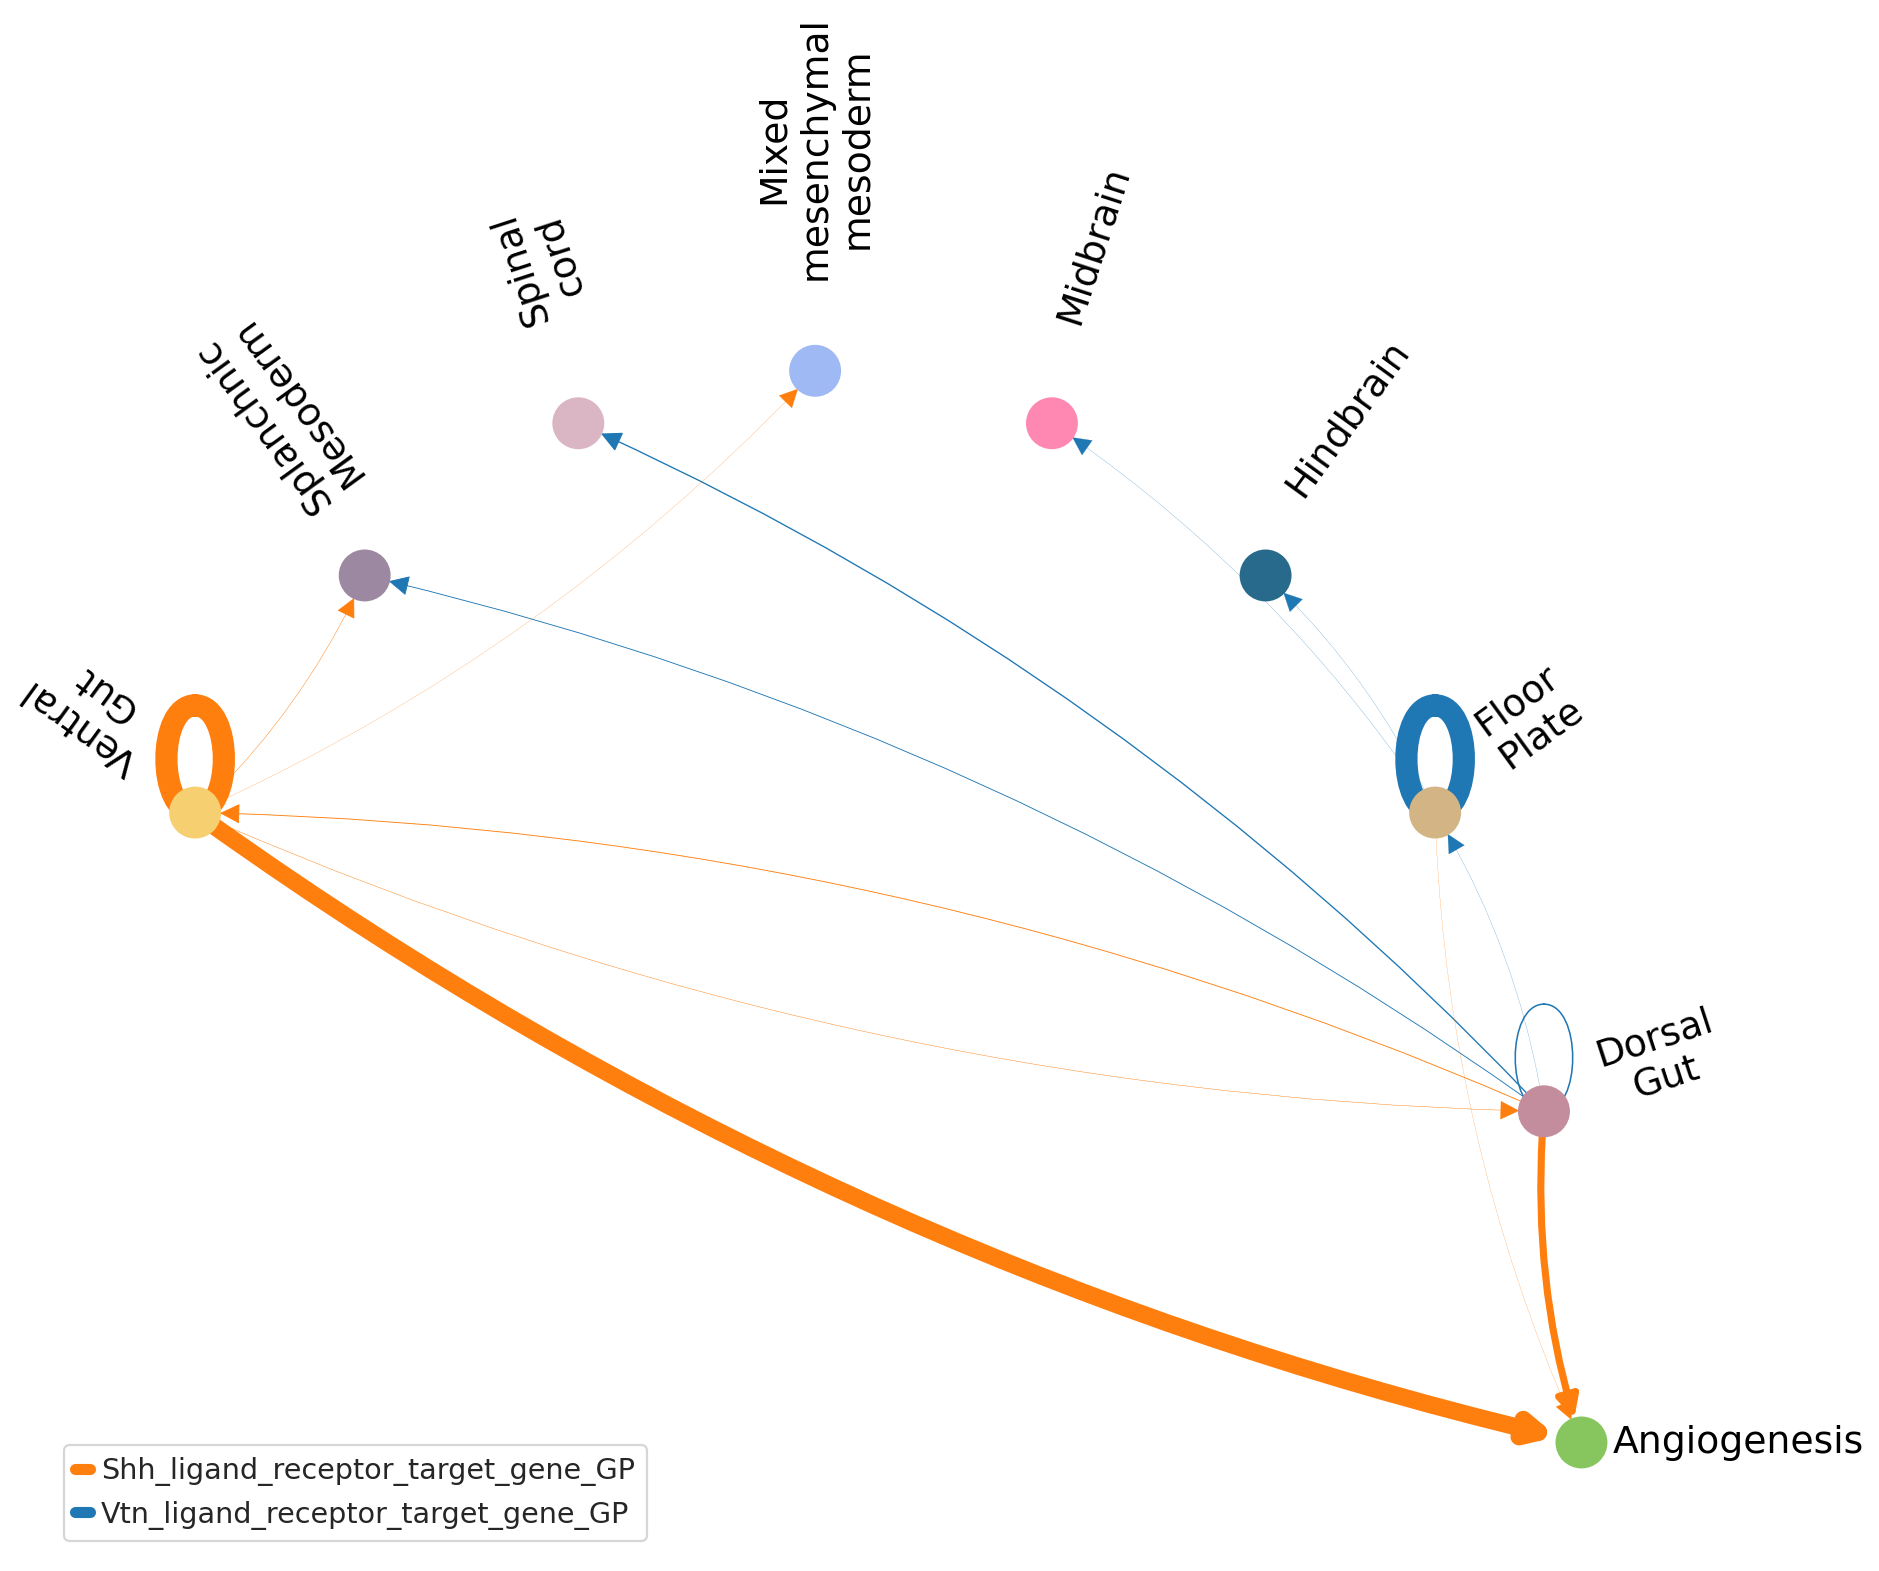

In [44]:
save = True
cat_key = "niche"
edge_attr = "strength"

niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
niche_abreviated_colors = {}

# Assuming you have unique edge types in your 'edge_type' column
edge_types = np.unique(network_df['edge_type'])
edge_type_colors = vega_10_scanpy

# Create a dictionary that maps edge types to colors
edge_type_color_dict = {edge_type: color for edge_type, color in zip(edge_types, edge_type_colors)}

for key, value in niche_colors.items():
    if "GP+ " in key:
        niche_abreviated_colors[key.split("GP+ ")[1].replace(" ", "\n")] = value
    else:
        niche_abreviated_colors[key] = value

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.axis("off")
G = nx.from_pandas_edgelist(
    network_df,
    source="source",
    target="target",
    edge_attr=["edge_type", edge_attr],
    create_using=nx.DiGraph(),
)
nodes = np.unique(network_df["target"])
node_colors = [niche_abreviated_colors[node] for node in nodes]
pos = nx.circular_layout(G)

nx.set_node_attributes(G, niche_abreviated_colors, "color")
node_color = nx.get_node_attributes(G, "color")

description = nx.draw_networkx_labels(G, pos, font_size=17)
n = model.adata.obs[cat_key].nunique()
node_list = sorted(G.nodes())
angle = []
angle_dict = {}
for i, node in zip(range(n), node_list):
    theta = 2.0 * np.pi * i / n
    angle.append((np.cos(theta), np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = text_space + bbdata.width / 2.0
    position = (radius * np.cos(angle_dict[node]), radius * np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node] * 360.0 / (2.0 * np.pi))
    t.set_clip_on(False)

edgelist = [(u, v) for u, v, e in G.edges(data=True) if u != v]
edge_colors = [edge_type_color_dict[edge_data['edge_type']] for u, v, edge_data in G.edges(data=True) if u != v]
width = [e[edge_attr] * edge_width_scale for u, v, e in G.edges(data=True) if u != v]

h2 = nx.draw_networkx(
    G,
    pos,
    with_labels=False,
    node_size=500,
    edgelist=edgelist,
    width=width,
    edge_vmin=0.0,
    edge_vmax=1.0,
    edge_color=edge_colors,  # Use the edge type colors here
    arrows=True,
    arrowstyle="-|>",
    arrowsize=20,
    vmin=0.0,
    vmax=1.0,
    cmap=plt.cm.binary,  # Use a colormap for node colors if needed
    node_color=list(node_color.values()),
    ax=ax,
    connectionstyle="arc3, rad = 0.1",
)

from matplotlib.lines import Line2D
#https://stackoverflow.com/questions/19877666/add-legends-to-linecollection-plot - uses plotted data to define the color but here we already have colors defined, so just need a Line2D object.
def make_proxy(clr, mappable, **kwargs):
    return Line2D([0, 1], [0, 1], color=clr, **kwargs)

# generate proxies with the above function
proxies = [make_proxy(clr, h2, lw=5) for clr in set(edge_colors)]
# and some text for the legend -- you should use something from df.
labels = edge_types
lgd = plt.legend(proxies, labels, loc="lower left")

edgelist = [(u, v) for u, v, e in G.edges(data=True) if ((u == v))] + [(u, v) for u, v, e in G.edges(data=True) if ((u != v))]
edge_colors = [edge_type_color_dict[edge_data['edge_type']] for u, v, edge_data in G.edges(data=True) if u == v]
width = [e[edge_attr] * edge_width_scale for u, v, e in G.edges(data=True) if u == v] + [0 for u, v, e in G.edges(data=True) if ((u != v))]
nx.draw_networkx_edges(
    G,
    pos,
    node_size=500,
    edgelist=edgelist, 
    width=width,
    edge_vmin=0.0,
    edge_vmax=1.0,
    edge_color=edge_colors,
    arrows=False,
    arrowstyle="-|>",
    arrowsize=20,
    ax=ax,
    connectionstyle="arc3",)
plt.tight_layout()
if save:
    plt.savefig(f"{figure_folder_path}/cci_network_vtn_shh.svg")
if show:
    plt.show()
plt.close(fig)
plt.ion()

In [ ]:
edgelist

In [ ]:
edgelist

In [ ]:
width

In [ ]:
edge_colors

In [ ]:
from nichecompass.utils import (extract_gp_dict_from_collectri_tf_network,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                get_unique_genes_from_gp_dict)

In [ ]:
species = "mouse"

In [ ]:
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"

In [ ]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_lr_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_categories=["ligand", "receptor"])

In [ ]:
nichenet_gp_dict["Shh_ligand_receptor_target_gene_GP"]

In [ ]:
if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    niche_annotation_dict = {
        "0": "striatum, caudeoputamen",
        "1": "L1-L4",
        "2": "striatum, lateral septum complex",
        "3": "L6a-L6b",
        "4": "Pallidum",
        "5": "L5-L6",
        "6": "L5-L6",
        "7": "prefrontal cortex",
        "8": "corpus callosum",
        "9": "dorsal striatum",
        "10": "L2-L3"
    }
    
    model.adata.obs["niche"] = model.adata.obs["latent_leiden_0.23"].map(niche_annotation_dict)
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    rna_cluster_colors = create_new_color_dict(
        adata=model.adata,
       cat_key=rna_cluster_key)
    atac_cluster_colors = create_new_color_dict(
        adata=model.adata,
       cat_key=atac_cluster_key)
    
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "rna_cluster_annotations_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="RNA Clusters",
        cat_key=rna_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=rna_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "atac_cluster_annotations_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="ATAC Clusters",
        cat_key=atac_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=atac_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    fig, ax = plt.subplots(figsize=(17, 17))
    sankey(
        x=model.adata.obs[rna_cluster_key],
        y=model.adata.obs["niche"],
        title="Original RNA Cluster Label vs NicheCompass Label",
        title_left="Original RNA Cluster Label",
        title_right="NicheCompass Label",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=model.adata.obs[latent_cluster_key].unique().tolist(),
        colors=rna_cluster_colors,
        #colorside="left",
        alpha=0.5,
    )
    plt.savefig(f"{figure_folder_path}/sankey_niche_to_rna_cluster.svg")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(17, 17))
    sankey(
        x=model.adata.obs[atac_cluster_key],
        y=model.adata.obs["niche"],
        title="Original ATAC Cluster Label vs NicheCompass Label",
        title_left="Original ATAC Cluster Label",
        title_right="NicheCompass Label",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=model.adata.obs[latent_cluster_key].unique().tolist(),
        colors=atac_cluster_colors,
        #colorside="left",
        alpha=0.5,
    )
    plt.savefig(f"{figure_folder_path}/sankey_niche_to_atac_cluster.svg")
    plt.show()
    
    rna_cluster_colors = create_new_color_dict(
        adata=model.adata,
       cat_key=rna_cluster_key)
    atac_cluster_colors = create_new_color_dict(
        adata=model.adata,
       cat_key=atac_cluster_key)
    
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "rna_cluster_annotations_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="RNA Clusters",
        cat_key=rna_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=rna_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "atac_cluster_annotations_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="ATAC Clusters",
        cat_key=atac_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=atac_cluster_colors,
        size=None,
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
tmp["niche"].reindex(custom_order)

In [ ]:
df = model.adata.obs.groupby(['niche', cell_type_key]).size().reset_index(name = 'counts')

grouped = df.groupby('niche')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)
for group in df['niche'].unique():
    temp_df = df[df['niche'] == group]
    
    data = dict(zip(temp_df[cell_type_key], temp_df['waffle_counts']))
    fig = plt.figure(
        FigureClass = Waffle, 
        rows = 8, 
        values = data, 
        title = {'label': f'Group {group}', 'loc': 'left'},
        labels = [f"{k} ({v}%)" for k, v in zip(temp_df[cell_type_key], temp_df['proportions'].round(2))],
        #legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
        legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 12, 'framealpha': 0},
        figsize = (40, 4)
    )
    plt.show()

In [ ]:
sc.pl.spatial(
    adata=model.adata,
    color="celltype_mapped_refined",
    groups="Mixed mesenchymal mesoderm",
    spot_size=spot_size,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 

In [ ]:
model.adata.obs[["Ccl1_ligand_receptor_target_gene_GP", "niche"]].groupby("niche").mean()

In [ ]:
gps = [
    "Ccl1_ligand_receptor_target_gene_GP", "IGF2_ligand_receptor_GP",
    "BMP4_ligand_receptor_GP", "Wnt5b_ligand_receptor_target_gene_GP",
    "Pgf_ligand_receptor_target_gene_GP", "Wnt6_ligand_receptor_target_gene_GP",
    "Vitamin_A_metabolite_enzyme_sensor_GP", "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
    "Edn1_ligand_receptor_target_gene_GP", "NPPA_ligand_receptor_GP",
    "Oxt_ligand_receptor_target_gene_GP", "PDGFC_ligand_receptor_GP",
    "IHH_ligand_receptor_GP", "Wnt5a_ligand_receptor_target_gene_GP",
    "Lama5_ligand_receptor_target_gene_GP", "PDGFA_ligand_receptor_GP",    
    "Guanine_metabolite_enzyme_sensor_GP", "Slitrk1_ligand_receptor_target_gene_GP",
    "Tgfbi_ligand_receptor_target_gene_GP", "Vegfc_ligand_receptor_target_gene_GP",    
    "Epo_ligand_receptor_target_gene_GP", "Thpo_ligand_receptor_target_gene_GP",    
    "Il10_ligand_receptor_target_gene_GP", "Fgf2_ligand_receptor_target_gene_GP", 
    "Fgf17_ligand_receptor_target_gene_GP", "Reln_ligand_receptor_target_gene_GP",    
    "Oleic_acid_metabolite_enzyme_sensor_GP", "L-Threonine_metabolite_enzyme_sensor_GP",    
    "Calca_ligand_receptor_target_gene_GP", "Shh_ligand_receptor_target_gene_GP",    
    "Gdf10_ligand_receptor_target_gene_GP", "Fgf3_ligand_receptor_target_gene_GP",    
    "Vip_ligand_receptor_target_gene_GP", "Fgf8_ligand_receptor_target_gene_GP", 
    "Ncam1_ligand_receptor_target_gene_GP", "IL6ST_ligand_receptor_GP",
    "Fgf18_ligand_receptor_target_gene_GP", "Dll1_ligand_receptor_target_gene_GP",
]

df = model.adata.obs[["niche"] + gps].groupby("niche").mean()
df = df.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::-1])

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index
normalized_df.columns = [col.split("_lig")[0].split("_met")[0] for col in normalized_df.columns]

plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(normalized_df,
            cmap='magma',
            annot=False,
            linewidths=0)
plt.xticks(rotation=90,
           ha='center')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sankey(
    x=adata_query_label_transfer.obs[ground_truth_key],
    y=adata_query_label_transfer.obs[transfer_label_key],
    title=“Original label vs. predicted annotation”,
    title_left=“Original label”,
    title_right=“Predicted annotation”,
    ax=ax,
    fontsize=“5",  # “xx-small”,
    left_order=adata_query_label_transfer.obs[ground_truth_key].unique().tolist(),
    colorside=“left”,
    alpha=0.5,
)
plt.show()

### 3.2 Analyze GPs & GP Genes

In [ ]:
# Get gp scores of all gps (active & inactive)
latent, _ = model.get_latent_representation(
    adata=model.adata,
    counts_key=counts_key,
    adj_key=adj_key,
    condition_key=condition_key,
    only_active_gps=False,
    return_mu_std=True,
    node_batch_size=model.node_batch_size_)

# Store gp scores, spatial coords and spatial neighbor graph in new adata
gp_adata = ad.AnnData(latent)
gp_adata.obs_names = model.adata.obs_names
gp_adata.var_names = model.adata.uns[gp_names_key]
gp_adata.obs[condition_key] = model.adata.obs[condition_key]
gp_adata.obsp[adj_key] = model.adata.obsp[adj_key]
gp_adata.obsm[spatial_key] = model.adata.obsm[spatial_key]

In [ ]:
# Compute spatial autocorrelation score Moran I of gene programs
# (higher score -> positive spatial autocorrelation)
sq.gr.spatial_autocorr(gp_adata,
                       mode="moran",
                       n_perms=100,
                       n_jobs=1)

# Add score to summary df
gp_summary_df["gp_moranI"] = gp_adata.uns["moranI"].loc[
    gp_summary_df["gp_name"].values.tolist(), "I"].values

In [ ]:
# Plot gp with highest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).head(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Plot gp with lowest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).tail(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Determine highly variable gene programs
hvgp_threshs = [0.1]

hvgp_list = []
hvgp_cols = []
for hvgp_thresh in hvgp_threshs:

    sc.pp.highly_variable_genes(
        gp_adata,
        n_top_genes=int(len(gp_adata.var) * hvgp_thresh),
        flavor="seurat",
        # batch_key=condition_key,
        subset=False)

    hvgp_list.append(gp_adata[:, gp_adata.var["highly_variable"]].var_names.tolist())
    
for i, hvgp_thresh in enumerate(hvgp_threshs):
    gp_summary_df[f"hvgp_{hvgp_thresh}_thresh"] = gp_summary_df["gp_name"].isin(hvgp_list[i])
    hvgp_cols.append(f"hvgp_{hvgp_thresh}_thresh")
    
gp_summary_df.loc[:, "gp_category"] = "inactive"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(active_gps), "gp_category"] = "active"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(hvgp_list[0]), "gp_category"] = "highly_variable"

In [ ]:
# Retrieve genes, gene importances, gene ranks, and mean gene expr of target and source genes respectively
gp_target_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_target_genes",
     "gp_target_genes_importances"] +
     hvgp_cols].explode(
        ["gp_target_genes",
         "gp_target_genes_importances"]).rename(
            columns={"gp_target_genes": "target_gene",
                     "gp_target_genes_importances": "target_gene_importance"}).dropna()
gp_target_genes_df["target_gene_rank"] = gp_target_genes_df.groupby("gp_name").cumcount() + 1
gp_target_genes_df["target_gene_importance"] = gp_target_genes_df["target_gene_importance"].astype(np.float32)
gp_target_genes_df["target_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_target_genes_df["target_gene"]].layers[counts_key].mean(0)).flatten()

gp_source_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_source_genes",
     "gp_source_genes_importances"] +
     hvgp_cols].explode(
        ["gp_source_genes",
         "gp_source_genes_importances"]).rename(
            columns={"gp_source_genes": "source_gene",
                     "gp_source_genes_importances": "source_gene_importance"}).dropna()
gp_source_genes_df["source_gene_rank"] = gp_source_genes_df.groupby("gp_name").cumcount() + 1
gp_source_genes_df["source_gene_importance"] = gp_source_genes_df["source_gene_importance"].astype(np.float32)
gp_source_genes_df["source_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_source_genes_df["source_gene"]].layers[counts_key].mean(0)).flatten()

In [ ]:
# Compute spatial autocorrelation score Moran I of genes
# (higher score -> positive spatial autocorrelation)
genes = list(set(list(gp_target_genes_df["target_gene"]) + list(gp_source_genes_df["source_gene"])))

sq.gr.spatial_autocorr(model.adata,
                       mode="moran",
                       genes=genes,
                       n_perms=100,
                       n_jobs=1)

target_genes_moranI_scores = []
for gene in gp_target_genes_df["target_gene"]:
    target_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_target_genes_df["gene_moranI"] = target_genes_moranI_scores

source_genes_moranI_scores = []
for gene in gp_source_genes_df["source_gene"]:
    source_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_source_genes_df["gene_moranI"] = source_genes_moranI_scores

In [ ]:
# Create summary plots over all gps, active gps, and inactive gps 
# with fixed n_top_genes
n_top_genes = 3
use_only_active_gps = False
    
gp_target_genes_df_top_genes = gp_target_genes_df[
    gp_target_genes_df["target_gene_rank"] <= n_top_genes]
gp_source_genes_df_top_genes = gp_source_genes_df[
    gp_source_genes_df["source_gene_rank"] <= n_top_genes]

all_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes
active_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    gp_target_genes_df_top_genes["gp_active"]]
inactive_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    ~gp_target_genes_df_top_genes["gp_active"]]

all_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes
active_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    gp_source_genes_df_top_genes["gp_active"]]
inactive_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    ~gp_source_genes_df_top_genes["gp_active"]]

# Plot distribution of gene importances
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axs = axs.flatten()
plt.suptitle("Gene Importance Distributions")
sns.histplot(all_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[0],
             bins=20)
axs[0].set(title="Target Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(all_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[1],
             bins=20)
axs[1].set(title="Source Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(active_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[2],
             bins=20)
axs[2].set(title="Target Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(active_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[3],
             bins=20)
axs[3].set(title="Source Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(inactive_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[4],
             bins=20)
axs[4].set(title="Target Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(inactive_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[5],
             bins=20)
axs[5].set(title="Source Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and log-normalized gene expression
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Mean Log-Normalized Gene Expression of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)};  "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and Moran's I score
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
gp_target_genes_moran_df = gp_target_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["target_gene_importance"] * x["gene_moranI"]).sum()}))
gp_target_genes_moran_df.reset_index(inplace=True)
gp_target_genes_moran_df = pd.merge(gp_target_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

gp_source_genes_moran_df = gp_source_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["source_gene_importance"] * x["gene_moranI"]).sum()}))
gp_source_genes_moran_df.reset_index(inplace=True)
gp_source_genes_moran_df = pd.merge(gp_source_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.scatterplot(data=gp_target_genes_moran_df,
                x=gp_target_genes_moran_df["gp_moranI"],
                y=gp_target_genes_moran_df["weighted_gene_moranI"],
                hue=gp_target_genes_moran_df["gp_active"],
                ax=axs[0])
axs[0].set(title="Target Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.scatterplot(data=gp_source_genes_moran_df,
                x=gp_source_genes_moran_df["gp_moranI"],
                y=gp_source_genes_moran_df["weighted_gene_moranI"],
                hue=gp_source_genes_moran_df["gp_active"],
                ax=axs[1])
axs[1].set(title="Source Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, top=0.8)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
# across all gps, active gps, and inactive gps

all_gp_target_genes_moran_df = gp_target_genes_moran_df
active_gp_target_genes_moran_df = gp_target_genes_moran_df[
    gp_target_genes_moran_df["gp_active"]]
inactive_gp_target_genes_moran_df = gp_target_genes_moran_df[
    ~gp_target_genes_moran_df["gp_active"]]

all_gp_source_genes_moran_df = gp_source_genes_moran_df
active_gp_source_genes_moran_df = gp_source_genes_moran_df[
    gp_source_genes_moran_df["gp_active"]]
inactive_gp_source_genes_moran_df = gp_source_genes_moran_df[
    ~gp_source_genes_moran_df["gp_active"]]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.regplot(x=all_gp_target_genes_moran_df["gp_moranI"],
            y=all_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=all_gp_source_genes_moran_df["gp_moranI"],
            y=all_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_target_genes_moran_df["gp_moranI"],
            y=active_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_source_genes_moran_df["gp_moranI"],
            y=active_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_moran_df["gp_moranI"],
                y=inactive_gp_target_genes_moran_df["weighted_gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_moran_df["gp_moranI"],
                y=inactive_gp_source_genes_moran_df["weighted_gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
target_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])
source_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])

for gp_type, gp_type_identifier in zip(["OmniPath", "NicheNet", "MEBOCOST"],
                                       ["receptor", "target", "metabolite"]):
    gp_type_target_genes_df = gp_target_genes_df[gp_target_genes_df["gp_name"].str.contains(gp_type_identifier)]
    gp_type_source_genes_df = gp_source_genes_df[gp_source_genes_df["gp_name"].str.contains(gp_type_identifier)]

    target_genes_weighted_moran_sub_df = gp_type_target_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["target_gene_importance"] * x["gene_moranI"]).sum() / x["target_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_target_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #target_genes_weighted_moran_sub_df = pd.concat([target_genes_weighted_moran_sub_df,
    #                                              new_df])
    target_genes_weighted_moran_sub_df["GP Type"] = gp_type
    target_genes_weighted_moran_sub_df["GP Category"] = target_genes_weighted_moran_sub_df.index
    target_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    target_genes_weighted_moran_df = pd.concat([target_genes_weighted_moran_df,
                                                target_genes_weighted_moran_sub_df])

    source_genes_weighted_moran_sub_df = gp_type_source_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["source_gene_importance"] * x["gene_moranI"]).sum() / x["source_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_source_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #source_genes_weighted_moran_sub_df = pd.concat([source_genes_weighted_moran_sub_df,
    #                                              new_df])
    source_genes_weighted_moran_sub_df["GP Type"] = gp_type
    source_genes_weighted_moran_sub_df["GP Category"] = source_genes_weighted_moran_sub_df.index
    source_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    source_genes_weighted_moran_df = pd.concat([source_genes_weighted_moran_df,
                                                source_genes_weighted_moran_sub_df])
    
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Mean Moran's I Score Weighted by NicheCompass Gene Importances ")
sns.stripplot(target_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

In [ ]:
# Create summary plots with variable n_top_genes
target_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])
source_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])

for n_top_genes in [5, 10, 20, 50, 100]:
    gp_target_genes_df_top_genes = gp_target_genes_df[gp_target_genes_df["target_gene_rank"] <= n_top_genes]
    gp_source_genes_df_top_genes = gp_source_genes_df[gp_source_genes_df["source_gene_rank"] <= n_top_genes]
    
    for gp_category in gp_target_genes_df_top_genes["gp_category"].unique().tolist():
        tmp_cat_df = gp_target_genes_df_top_genes.loc[gp_target_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["target_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        target_genes_corr_df = target_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
        tmp_cat_df = gp_source_genes_df_top_genes[gp_source_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["source_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        source_genes_corr_df = source_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Pearson Correlation between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.stripplot(target_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

### 3.3 Latent Cluster Analysis

#### 3.3.1 One Cluster (All) vs Rest of Tissue Differential GP Testing

In [ ]:
selected_cats = None
log_bayes_factor_thresh = 2.3 # 2.3 strong threshold; 4.6 decisive threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass Latent Cluster Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_heatmap.pdf"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

# Plot heatmap of enriched gps
ax = sc.pl.heatmap(model.adata,
                    enriched_gps,
                    show_gene_labels=True,
                    groupby=latent_cluster_key,
                    dendrogram=True,
                    swap_axes=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() * 1.5,
                             len(enriched_gps) / 2),
                    save=save_fig)
if save_fig:
    shutil.move("figures/heatmap.pdf", file_path)
    os.rmdir("figures")

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights",
                   "gp_target_genes_weights",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights",
        "gp_target_peaks_weights",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df["gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
save_figs = True

for i in np.arange(0, len(enriched_gps), 10):
    plot_label = f"res_{latent_leiden_resolution}_" \
                 f"latent_clusters_all_vs_rest_log_bayes_factor_" \
                 f"{log_bayes_factor_thresh}"

    generate_enriched_gp_info_plots(
        plot_label=plot_label,
        model=model,
        sample_key=sample_key,
        differential_gp_test_results_key=differential_gp_test_results_key,
        cat_key=latent_cluster_key,
        cat_palette=latent_cluster_colors,
        n_top_enriched_gp_start_idx=i,
        n_top_enriched_gp_end_idx=i+10,
        feature_spaces=samples, # ["latent"]
        n_top_genes_per_gp=5,
        n_top_peaks_per_gp=(0 if not multimodal else 5),
        scale_omics_ft=False,
        save_figs=save_figs,
        figure_folder_path=f"{figure_folder_path}/",
        spot_size=spot_size)
    
    gc.collect()

#### 3.2.2 One Cluster (Selected) vs Rest of Tissue Differential GP Testing

In [ ]:
latent_groups = ["3"]

In [ ]:
if len(latent_groups) > 0:
    title = f"NicheCompass Latent Cluster Enriched Gene Programs"
    log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}_enriched_gps_heatmap.pdf"

    # Run differential gp testing
    enriched_gps = model.run_differential_gp_tests(
        cat_key=latent_cluster_key,
        selected_cats=latent_groups,
        comparison_cats="rest",
        log_bayes_factor_thresh=log_bayes_factor_thresh)

    # Plot heatmap of enriched gps
    ax = sc.pl.heatmap(model.adata,
                        enriched_gps,
                        show_gene_labels=True,
                        groupby=latent_cluster_key,
                        dendrogram=True,
                        swap_axes=True,
                        figsize=(model.adata.obs[latent_cluster_key].nunique() * 1.5,
                                 len(enriched_gps) / 2),
                        save=save_fig)
    if save_fig:
        shutil.move("figures/heatmap.pdf", file_path)
        os.rmdir("figures")

In [ ]:
if len(latent_groups) > 0:
    save_file = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

    gp_summary_cols = ["gp_name",
                       "n_source_genes",
                       "n_non_zero_source_genes",
                       "n_target_genes",
                       "n_non_zero_target_genes",
                       "gp_source_genes",
                       "gp_target_genes",
                       "gp_source_genes_weights",
                       "gp_target_genes_weights",
                       "gp_source_genes_importances",
                       "gp_target_genes_importances"]
    if multimodal:
        gp_summary_cols = gp_summary_cols + [
            "n_source_peaks",
            "n_target_peaks",
            "gp_source_peaks",
            "gp_target_peaks",
            "gp_source_peaks_weights",
            "gp_target_peaks_weights",
            "gp_source_peaks_importances",
            "gp_target_peaks_importances"]

    # Get summary of enriched gene programs
    enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
    cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
    enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
    enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
    enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

    if save_file:
        enriched_gp_summary_df.to_csv(f"{file_path}")
    else:
        display(enriched_gp_summary_df)

In [ ]:
if len(latent_groups) > 0:
    save_figs = True

    for i in np.arange(0, len(enriched_gps), 10):
        plot_label = f"res_{latent_leiden_resolution}_" \
                    f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                    f"{log_bayes_factor_thresh}"

        generate_enriched_gp_info_plots(
            plot_label=plot_label,
            model=model,
            sample_key=sample_key,
            differential_gp_test_results_key=differential_gp_test_results_key,
            cat_key=latent_cluster_key,
            cat_palette=latent_cluster_colors,
            n_top_enriched_gp_start_idx=i,
            n_top_enriched_gp_end_idx=i+10,
            feature_spaces=["p22"], # ["latent"]
            n_top_genes_per_gp=5,
            n_top_peaks_per_gp=(0 if not multimodal else 5),
            scale_omics_ft=False,
            save_figs=save_figs,
            figure_folder_path=f"{figure_folder_path}/",
            spot_size=spot_size)

        gc.collect()

### 3.4 Cell Type Analysis

In [ ]:
cell_type = "Gut tube" # "Forebrain/Midbrain/Hindbrain", "Gut tube"
cell_type_fmt = cell_type.replace('/', '_').lower()
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"
cell_type_latent_cluster_differential_gp_scores_key = f"{cell_type}_latentn_cluster_differential_gp_scores"

#### 3.4.1 Overview

In [ ]:
# Plot cell type in physical and latent space
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    sample_key=sample_key,
                                    cell_type_key=cell_type_key,
                                    cell_type_colors=cell_type_colors,
                                    figure_folder_path=figure_folder_path,
                                    save_fig=True)

#### 3.4.2 Cell Type vs Rest of Tissue Differential GP Testing

In [ ]:
selected_cats = [cell_type]
log_bayes_factor_thresh = 2.3 # 2.3 strong threshold; 4.6 decisive threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass {cell_type} Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=cell_type_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

sc.pl.heatmap(model.adata,
              enriched_gps,
              show_gene_labels=True,
              groupby=cell_type_key,
              dendrogram=True,
              swap_axes=True,
              figsize=(model.adata.obs[cell_type_key].nunique() * 1.5,
                       len(enriched_gps) / 2))

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights",
                   "gp_target_genes_weights",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights",
        "gp_target_peaks_weights",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df["gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
save_figs = True

for i in np.arange(0, len(enriched_gps), 10):
    plot_label = f"{cell_type_fmt}_vs_rest_log_bayes_factor_" \
                 f"{log_bayes_factor_thresh}"

    generate_enriched_gp_info_plots(
        plot_label=plot_label,
        model=model,
        sample_key=sample_key,
        differential_gp_test_results_key=differential_gp_test_results_key,
        cat_key=cell_type_key,
        cat_palette=cell_type_colors,
        n_top_enriched_gp_start_idx=i,
        n_top_enriched_gp_end_idx=i+10,
        feature_spaces=samples, # ["latent"]
        n_top_genes_per_gp=5,
        n_top_peaks_per_gp=(0 if not multimodal else 5),
        scale_omics_ft=False,
        save_figs=save_figs,
        figure_folder_path=f"{figure_folder_path}/",
        spot_size=spot_size)
    
    gc.collect()

### 3.5 Save Results

In [ ]:
if log_norm_omics_features:
    # Log normalize counts for cellxgene server
    sc.pp.normalize_total(model.adata, target_sum=1e4)
    sc.pp.log1p(model.adata)

In [ ]:
# Store gp summary in adata
gp_summary = model.get_gp_summary()
for col in gp_summary.columns:
    gp_summary[col] = gp_summary[col].astype(str)
model.adata.uns["nichecompass_gp_summary"] = gp_summary

In [ ]:
model.adata.write(f"{result_folder_path}/{dataset}_analysis.h5ad")

In [ ]:
- Forebrain/Midbrain/Hindbrain: Regionally specific developing brain subtypes: separation into Rhombencephalon, Tegmentum, Mesencephalon, Prosencephalon
- Mixed Mesenchymal Mesoderm: "mixed mesenchymal mesoderm, represent 
a cell state rather than a defined cell type. Mesenchyme represents  a  state  in  which  cells  express  markers  characteristic  of  migratory   cells loosely dispersed within an extracellular matrix56. This strong  overriding transcriptional signature of mesenchyme, irrespective of  location,  makes  it  challenging  to  distinguish  which  cell  types  this   mixed  mesenchymal  mesoderm  population  represents  using  clas- sical scRNA-seq data"

We can identify distinct subpopulations that are spatially defined.
Cardiomyocytes are spatially and morphologically distinct from other cell types, endothelium is interspersed and spread across the entire embryo space.

In [ ]:
f"{result_folder_path}/{dataset}"